# EPASS Implementation for Semi-Supervised Learning on Tiny ImageNet

This notebook implements the EPASS (Ensemble Projectors Aided for Semi-supervised Learning) method described in the paper 'Debiasing, calibrating, and improving Semi-supervised Learning performance via simple Ensemble Projector' on the Tiny ImageNet dataset.

**Core Ideas:**
1.  **Semi-Supervised Learning (SSL):** Leverage a small amount of labeled data and a large amount of unlabeled data.
2.  **Contrastive Joint Training:** Combine supervised classification with contrastive representation learning (like SimMatch/CoMatch).
3.  **EPASS:** Replace the single projection head (MLP mapping encoder features to embeddings) with an *ensemble* of projectors. The outputs are averaged to produce a more robust, less biased embedding.
4.  **Framework:** We will implement a simplified SSL framework inspired by FixMatch/SimMatch and integrate EPASS into it.
    *   Use weak and strong augmentations.
    *   Generate pseudo-labels for unlabeled data using an EMA (Exponential Moving Average) teacher model.
    *   Combine supervised loss (labeled), unsupervised consistency loss (unlabeled), and a simplified contrastive loss (using EPASS embeddings).

**Dataset:** Tiny ImageNet (200 classes, 64x64 images).

**Key Modification (Based on Tiny-ImageNet Classifier Analysis):**
*   Standard ResNet18's initial layers (`conv1`, `maxpool`) downsample 64x64 images too aggressively.
*   We modify `conv1` to use a `3x3` kernel with `stride=1`, `padding=1`.
*   We remove the initial `maxpool` layer.
*   This preserves spatial information better in early layers, crucial for smaller images.

## 1. Setup and Imports

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os
import random
import math
import copy
import zipfile
from tqdm.notebook import tqdm
import gc # Garbage collector

import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Configuration

In [2]:
# Device Configuration
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# Data Parameters
DATA_DIR = 'tiny-imagenet-200'
NUM_CLASSES = 200
IMG_SIZE = 64 # Original image size
INPUT_SIZE = 64 # Size after transformations

# SSL Parameters
labeled_ratio = 0.1  # Fraction of training data to use as labeled (e.g., 10%)
batch_size = 128      # Combined batch size (increase if GPU allows)
mu = 3               # Ratio of unlabeled data to labeled data in a batch (e.g., 3*labeled_bs = unlabeled_bs)
labeled_bs = batch_size // (mu + 1)
unlabeled_bs = batch_size - labeled_bs
confidence_threshold = 0.95 # Confidence threshold for pseudo-labeling (can tune this)

# EPASS Parameters
num_projectors = 3   # Number of projectors in the ensemble (K in the paper)
projection_dim = 128 # Dimension of the embedding space

# Training Parameters
epochs = 35          # Total training epochs (increased from 50)
learning_rate = 0.03 # Initial Learning Rate
momentum = 0.9
weight_decay = 5e-4
ema_decay = 0.999    # Decay rate for the EMA teacher model

# Loss Weights (Lambdas from Eq. 6 in the paper)
lambda_u = 1.0       # Weight for unsupervised consistency loss
lambda_c = 0.1       # Weight for contrastive loss (can tune this)
contrastive_temp = 0.1 # Temperature for contrastive loss (can tune this)

# Print derived batch sizes
print(f"Total Batch Size: {batch_size}")
print(f"Labeled Batch Size: {labeled_bs}")
print(f"Unlabeled Batch Size: {unlabeled_bs}")

Using device: cuda
Total Batch Size: 128
Labeled Batch Size: 32
Unlabeled Batch Size: 96


## 3. Data Download and Preparation

In [3]:
# Download and Unzip Data (if not already present)
if not os.path.exists(DATA_DIR):
    print("Downloading Tiny ImageNet...")
    # Retrieve data directly from Stanford data source
    try:
        !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
        print("Unzipping...")
        with zipfile.ZipFile('tiny-imagenet-200.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Data downloaded and extracted.")
        # Clean up zip file
        os.remove('tiny-imagenet-200.zip')
    except Exception as e:
        print(f"Error downloading/unzipping: {e}")
        print("Please download 'tiny-imagenet-200.zip' manually from http://cs231n.stanford.edu/tiny-imagenet-200.zip and unzip it.")
else:
    print("Tiny ImageNet directory already exists.")

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

# --- Validation Set Reorganization --- 
# This logic moves validation images into class-specific folders, needed for ImageFolder
val_img_dir = os.path.join(VALID_DIR, 'images')
val_annot_file = os.path.join(VALID_DIR, 'val_annotations.txt')
reorganized_val_dir = os.path.join(VALID_DIR, 'organized') # New target directory for validation images

if not os.path.exists(reorganized_val_dir):
    print("Reorganizing validation set...")
    os.makedirs(reorganized_val_dir, exist_ok=True)
    if os.path.exists(val_annot_file) and os.path.exists(val_img_dir):
        try:
            val_data = pd.read_csv(val_annot_file, sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
            val_img_dict = {row['File']: row['Class'] for index, row in val_data.iterrows()}

            for img, folder in tqdm(val_img_dict.items(), desc="Moving validation images"):
                newpath = os.path.join(reorganized_val_dir, folder)
                os.makedirs(newpath, exist_ok=True)
                
                current_img_path = os.path.join(val_img_dir, img)
                new_img_path = os.path.join(newpath, img)
                
                if os.path.exists(current_img_path) and not os.path.exists(new_img_path):
                     os.rename(current_img_path, new_img_path)

            print("Validation set reorganized into:", reorganized_val_dir)
            VALID_DIR_LOADER = reorganized_val_dir # Use this path for the DataLoader
        except Exception as e:
            print(f"Error reorganizing validation set: {e}")
            # Fallback: Check if original val/images contains class folders (maybe reorganized before)
            try:
                example_class_folder = os.listdir(TRAIN_DIR)[0] # Get an example class name
                if os.path.exists(os.path.join(val_img_dir, example_class_folder)):
                     print("Using existing validation subfolder structure in val/images.")
                     VALID_DIR_LOADER = val_img_dir # Use the original image folder
                else:
                     raise ValueError("Validation set structure problem.")
            except:
                 raise ValueError("Validation set structure problem. Could not reorganize or find existing structure.")
    else:
         raise FileNotFoundError(f"Required validation files not found: {val_annot_file} or {val_img_dir}")
else:
    print("Using previously reorganized validation set:", reorganized_val_dir)
    VALID_DIR_LOADER = reorganized_val_dir

# --- Load Class Names --- 
class_to_name_dict = dict()
words_file = os.path.join(DATA_DIR, 'words.txt')
if os.path.exists(words_file):
    fp = open(words_file, 'r')
    data = fp.readlines()
    for line in data:
        words = line.strip('\n').split('\t')
        if len(words) >= 2:
             class_to_name_dict[words[0]] = words[1].split(',')[0]
    fp.close()
    print(f"Loaded {len(class_to_name_dict)} class names.")
else:
    print("Warning: words.txt not found. Cannot map class IDs to names.")

--2025-04-13 17:43:37--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-04-13 17:43:37--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.1MB/s    in 6.5s    

2025-04-13 17:43:44 (36.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Unzipping...
Data downloaded and extracted.
Reorganizing validation set...


Moving validation images:   0%|          | 0/10000 [00:00<?, ?it/s]

Validation set reorganized into: tiny-imagenet-200/val/organized
Loaded 82115 class names.


## 4. Augmentations and Datasets

In [4]:
# ImageNet normalization values
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Weak Augmentation (for labeled data and teacher model's unlabeled input)
transform_weak = T.Compose([
    T.RandomResizedCrop(INPUT_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

# Strong Augmentation (for student model's unlabeled input)
transform_strong = T.Compose([
    T.RandomResizedCrop(INPUT_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=10), # Apply RandAugment
    T.ToTensor(),
    normalize
])

# Standard transform for validation
transform_val = T.Compose([
    # No resizing needed if INPUT_SIZE == IMG_SIZE
    # T.Resize(INPUT_SIZE), # Keep commented if input is 64
    # T.CenterCrop(INPUT_SIZE),
    T.ToTensor(),
    normalize
])

# --- Custom Datasets for SSL ---
class TinyImageNetLabeled(Dataset):
    def __init__(self, root, indices, transform):
        # Use datasets.ImageFolder to easily get paths and targets
        temp_dataset = datasets.ImageFolder(root)
        self.base_path = root
        self.samples = [(temp_dataset.samples[i][0], temp_dataset.targets[i]) for i in indices]
        self.transform = transform
        self.loader = temp_dataset.loader # Use the default loader
        del temp_dataset # Free memory

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

class TinyImageNetUnlabeled(Dataset):
    def __init__(self, root, indices, transform_weak, transform_strong):
        temp_dataset = datasets.ImageFolder(root)
        self.base_path = root
        # Only store paths for unlabeled data
        self.samples = [temp_dataset.samples[i][0] for i in indices] 
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong
        self.loader = temp_dataset.loader
        del temp_dataset

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        img = self.loader(path)
        img_weak = self.transform_weak(img)
        img_strong = self.transform_strong(img)
        return img_weak, img_strong

# --- Create Labeled/Unlabeled Split ---
print("Creating train/validation datasets...")
base_train_dataset = datasets.ImageFolder(TRAIN_DIR)
val_dataset = datasets.ImageFolder(VALID_DIR_LOADER, transform=transform_val)
num_train_samples = len(base_train_dataset)
num_labeled_samples = int(labeled_ratio * num_train_samples)

print(f"Total training samples: {num_train_samples}")
print(f"Using {num_labeled_samples} labeled samples ({labeled_ratio*100}%)")

# Ensure class balance in the labeled set
targets = np.array(base_train_dataset.targets)
labeled_indices = []
unlabeled_indices = []
samples_per_class = num_labeled_samples // NUM_CLASSES

if samples_per_class == 0:
    raise ValueError(f"labeled_ratio ({labeled_ratio}) is too small for {NUM_CLASSES} classes, resulting in 0 samples per class.")

print(f"Aiming for {samples_per_class} labeled samples per class.")

for i in range(NUM_CLASSES):
    class_indices = np.where(targets == i)[0]
    np.random.shuffle(class_indices)
    labeled_indices.extend(class_indices[:samples_per_class])
    unlabeled_indices.extend(class_indices[samples_per_class:])

num_labeled_actual = len(labeled_indices)
num_unlabeled_actual = len(unlabeled_indices)
print(f"Actual labeled samples: {num_labeled_actual}")
print(f"Actual unlabeled samples: {num_unlabeled_actual}")

# Create the datasets
print("Creating labeled/unlabeled datasets...")
labeled_dataset = TinyImageNetLabeled(TRAIN_DIR, labeled_indices, transform=transform_weak)
unlabeled_dataset = TinyImageNetUnlabeled(TRAIN_DIR, unlabeled_indices, 
                                          transform_weak=transform_weak, 
                                          transform_strong=transform_strong)
# Clear base dataset from memory
del base_train_dataset
gc.collect()

# --- Create DataLoaders ---
print("Creating DataLoaders...")
num_iterations = len(unlabeled_dataset) // unlabeled_bs
if num_iterations == 0:
    raise ValueError(f"Unlabeled batch size ({unlabeled_bs}) is larger than unlabeled dataset size ({len(unlabeled_dataset)}). Decrease batch size or mu.")

dataloader_num_workers = 2 if use_cuda else 0 # Use workers only if GPU is available

labeled_loader = DataLoader(
    labeled_dataset,
    batch_size=labeled_bs,
    shuffle=True,
    num_workers=dataloader_num_workers,
    pin_memory=use_cuda,
    drop_last=True
)

unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=unlabeled_bs,
    shuffle=True,
    num_workers=dataloader_num_workers,
    pin_memory=use_cuda,
    drop_last=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=dataloader_num_workers,
    pin_memory=use_cuda
)

print(f"Labeled loader batches per epoch: {len(labeled_loader)}")
print(f"Unlabeled loader batches per epoch: {len(unlabeled_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Number of iterations per epoch (based on unlabeled data): {num_iterations}")

Creating train/validation datasets...
Total training samples: 100000
Using 10000 labeled samples (10.0%)
Aiming for 50 labeled samples per class.
Actual labeled samples: 10000
Actual unlabeled samples: 90000
Creating labeled/unlabeled datasets...
Creating DataLoaders...
Labeled loader batches per epoch: 312
Unlabeled loader batches per epoch: 937
Validation loader batches: 79
Number of iterations per epoch (based on unlabeled data): 937


## 5. Model Definition (Encoder + EPASS Projector + Classifier)

**Crucially, we modify the ResNet18 backbone here for Tiny ImageNet:**
*   `conv1`: Changed to `kernel_size=3, stride=1, padding=1`
*   `maxpool`: Changed to `nn.Identity()` (effectively removed)

In [5]:
class MLPProjector(nn.Module):
    """Simple MLP projector head as used in SimCLR, MoCo, etc."""
    def __init__(self, input_dim, hidden_dim=512, output_dim=128): # Reduced hidden dim
        super().__init__()
        # Using BatchNorm and ReLU
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.block(x)

def create_modified_resnet18(pretrained=True):
    """Creates a ResNet18 model modified for 64x64 input."""
    model = models.resnet18(pretrained=False) # Load architecture, not weights yet
    
    # Modify conv1 and maxpool for 64x64 input
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity() # Remove maxpool layer
    
    if pretrained:
        print("Loading ImageNet pretrained weights (excluding conv1)...")
        # Load official pretrained weights
        state_dict = models.resnet18(pretrained=True).state_dict()
        
        # Remove weights for layers that changed shape/existence
        # Specifically, conv1's weight and potentially fc (though we replace fc later)
        del state_dict['conv1.weight']
        if 'fc.weight' in state_dict: del state_dict['fc.weight']
        if 'fc.bias' in state_dict: del state_dict['fc.bias']
            
        # Load the remaining weights
        # strict=False allows loading even if some keys are missing (like our modified conv1)
        missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
        print("Pretrained weights loaded.")
        print(f"Missing keys: {missing_keys}") # Should include conv1.weight
        print(f"Unexpected keys: {unexpected_keys}") # Should be empty if fc removed before load
        
    return model

class EPASS_Model(nn.Module):
    def __init__(self, backbone, num_classes, num_projectors, projection_dim):
        super().__init__()
        self.backbone = backbone
        
        # Get the feature dimension (should be 512 for ResNet18 before fc)
        # We removed the original fc layer in create_modified_resnet18 or will remove it now
        if hasattr(backbone, 'fc'):
             self.feature_dim = backbone.fc.in_features
             # Remove the original classifier
             self.backbone.fc = nn.Identity()
        else: # If fc was already removed (e.g., by Timm models)
             # Find the layer before the identity fc - usually avgpool
             # This is brittle, better to assume ResNet structure here
             self.feature_dim = 512 # Hardcode for ResNet18
             print("Warning: Backbone has no fc layer. Assuming ResNet18 feature dim (512).")
             # Ensure the final layer of backbone IS identity if it exists
             if hasattr(self.backbone, 'classifier'): 
                 self.backbone.classifier = nn.Identity()
        
        print(f"Backbone feature dimension: {self.feature_dim}")

        # Classification Head
        self.classifier = nn.Linear(self.feature_dim, num_classes)

        # EPASS Projectors
        self.num_projectors = num_projectors
        self.projectors = nn.ModuleList([
            MLPProjector(self.feature_dim, output_dim=projection_dim)
            for _ in range(num_projectors)
        ])

    def forward(self, x, return_features=False, return_projection=False):
        features = self.backbone(x) # Shape should be [batch_size, self.feature_dim]
        # The create_modified_resnet18 includes AdaptiveAvgPool implicitly before fc
        # So 'features' should already be the correct shape
        
        logits = self.classifier(features)

        if return_projection:
            projected_embeddings = []
            for projector in self.projectors:
                projected_embeddings.append(projector(features))
            
            # Stack and average along the new dimension (dim=0)
            ensembled_embedding = torch.mean(torch.stack(projected_embeddings, dim=0), dim=0)
            # Normalize the ensembled embedding
            ensembled_embedding = F.normalize(ensembled_embedding, dim=1)
            
            if return_features:
                return logits, features, ensembled_embedding
            else:
                return logits, ensembled_embedding
        else:
            if return_features:
                return logits, features
            else:
                return logits

# --- Instantiate Models (Student and Teacher) ---
print("Creating student model...")
backbone_student = create_modified_resnet18(pretrained=True)
student_model = EPASS_Model(backbone_student, NUM_CLASSES, num_projectors, projection_dim).to(device)

print("Creating teacher model...")
backbone_teacher = create_modified_resnet18(pretrained=False) # Teacher starts same arch, no pretrain needed
teacher_model = EPASS_Model(backbone_teacher, NUM_CLASSES, num_projectors, projection_dim).to(device)

# Initialize teacher with student weights and detach
print("Initializing teacher weights from student...")
for param_teacher, param_student in zip(teacher_model.parameters(), student_model.parameters()):
    param_teacher.data.copy_(param_student.data)
    param_teacher.requires_grad = False

print("Student and Teacher models created and initialized.")

# Optional: Print model summary
# try:
#     from torchsummary import summary
#     print("Student Model Summary:")
#     summary(student_model, input_size=(3, INPUT_SIZE, INPUT_SIZE))
# except ImportError:
#     print("torchsummary not installed. Skipping summary.")
#     print(student_model)

Creating student model...
Loading ImageNet pretrained weights (excluding conv1)...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


Pretrained weights loaded.
Missing keys: ['conv1.weight', 'fc.weight', 'fc.bias']
Unexpected keys: []
Backbone feature dimension: 512
Creating teacher model...
Backbone feature dimension: 512
Initializing teacher weights from student...
Student and Teacher models created and initialized.


## 6. Loss Functions and Optimizer

In [6]:
# Supervised Loss
criterion_s = nn.CrossEntropyLoss()

# Unsupervised Consistency Loss (using pseudo-labels)
criterion_u = nn.CrossEntropyLoss(reduction='none')

# Contrastive Loss (Simplified)
def contrastive_loss(emb_student_strong, emb_teacher_weak, temperature):
    # Maximize cosine similarity = Minimize negative cosine similarity
    sim = torch.sum(emb_student_strong * emb_teacher_weak, dim=1) # Assumes embeddings are normalized
    loss = -sim / temperature
    return loss.mean()

# Optimizer
optimizer = optim.SGD(student_model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum, 
                      weight_decay=weight_decay,
                      nesterov=True)

# Learning Rate Scheduler
# T_max should be total number of steps (iterations * epochs)
# Recalculate T_max here in case num_iterations changed
total_train_steps = num_iterations * epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_train_steps)
print(f"Cosine LR Scheduler initialized with T_max = {total_train_steps}")

# Function for EMA update
@torch.no_grad()
def update_ema_variables(model, ema_model, alpha, global_step):
    alpha = min(1 - 1 / (global_step + 1), alpha) # Ramp-up EMA decay
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(param.data, alpha=1 - alpha)

Cosine LR Scheduler initialized with T_max = 32795


## 7. Training Loop

In [7]:
def train_one_epoch(student_model, teacher_model, labeled_loader, unlabeled_loader, optimizer, scheduler, epoch, num_iterations, total_steps):
    student_model.train()
    teacher_model.eval()

    total_loss_s, total_loss_u, total_loss_c, total_loss = 0.0, 0.0, 0.0, 0.0
    mask_ratio_acc = 0.0
    labeled_processed, unlabeled_processed = 0, 0

    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    
    pbar = tqdm(range(num_iterations), desc=f"Epoch {epoch+1}/{epochs}")

    for i in pbar:
        try:
            images_l, targets_l = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            images_l, targets_l = next(labeled_iter)

        try:
            images_uw, images_us = next(unlabeled_iter)
        except StopIteration:
             print("Warning: Unlabeled loader exhausted unexpectedly.")
             break 
        
        # Move data to device
        images_l, targets_l = images_l.to(device), targets_l.to(device)
        images_uw, images_us = images_uw.to(device), images_us.to(device)

        # --- Forward pass --- 
        bs_l = images_l.shape[0]
        bs_u = images_uw.shape[0]

        logits_l = student_model(images_l)
        loss_s = criterion_s(logits_l, targets_l)

        logits_us, emb_us = student_model(images_us, return_projection=True)
        
        with torch.no_grad():
            logits_uw, emb_uw = teacher_model(images_uw, return_projection=True)

        # --- Unsupervised Loss --- 
        pseudo_label = torch.softmax(logits_uw, dim=-1)
        max_probs, targets_u = torch.max(pseudo_label, dim=-1)
        mask = max_probs.ge(confidence_threshold).float()
        
        loss_u_all = criterion_u(logits_us, targets_u)
        # Only average over samples where mask is 1
        # Add a small epsilon to avoid division by zero if mask sum is 0
        loss_u = (torch.sum(loss_u_all * mask) / (mask.sum() + 1e-6))
        mask_ratio = mask.mean().item()

        # --- Contrastive Loss --- 
        loss_c = contrastive_loss(emb_us, emb_uw, contrastive_temp)
        
        # --- Total Loss --- 
        # Handle cases where mask_ratio is 0 (loss_u might be NaN/Inf)
        if torch.isnan(loss_u) or torch.isinf(loss_u):
             # If no samples meet threshold, Lu is effectively 0
             total_batch_loss = loss_s + lambda_c * loss_c 
             loss_u_item = 0.0 # For logging
        else:
             total_batch_loss = loss_s + lambda_u * loss_u + lambda_c * loss_c
             loss_u_item = loss_u.item()

        # --- Backward pass and Optimization --- 
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()
        scheduler.step() 

        # --- Update Teacher Model (EMA) --- 
        global_step = epoch * num_iterations + i
        update_ema_variables(student_model, teacher_model, ema_decay, global_step)

        # --- Accumulate losses for logging ---
        loss_s_item = loss_s.item()
        loss_c_item = loss_c.item()
        total_loss_s += loss_s_item * bs_l
        total_loss_u += loss_u_item * bs_u # Using item after NaN check
        total_loss_c += loss_c_item * bs_u
        total_loss += total_batch_loss.item() # This might be less accurate if loss_u was zeroed
        mask_ratio_acc += mask_ratio
        labeled_processed += bs_l
        unlabeled_processed += bs_u

        # Update progress bar
        pbar.set_postfix({
            'Ls': f'{loss_s_item:.4f}', 
            'Lu': f'{loss_u_item:.4f}', 
            'Lc': f'{loss_c_item:.4f}',
            'Mask': f'{mask_ratio:.2f}', 
            'LR': f'{optimizer.param_groups[0]["lr"]:.1e}'
        })

    # Calculate average losses for the epoch
    avg_loss_s = total_loss_s / labeled_processed if labeled_processed > 0 else 0
    avg_loss_u = total_loss_u / unlabeled_processed if unlabeled_processed > 0 else 0
    avg_loss_c = total_loss_c / unlabeled_processed if unlabeled_processed > 0 else 0
    avg_loss = (total_loss_s + total_loss_u + total_loss_c) / (labeled_processed + unlabeled_processed) if (labeled_processed + unlabeled_processed) > 0 else 0 # More accurate avg
    avg_mask_ratio = mask_ratio_acc / num_iterations if num_iterations > 0 else 0

    print(f"Epoch {epoch+1} Summary: Avg Loss: {avg_loss:.4f}, Ls: {avg_loss_s:.4f}, Lu: {avg_loss_u:.4f}, Lc: {avg_loss_c:.4f}, Mask Ratio: {avg_mask_ratio:.4f}")
    return avg_loss, avg_mask_ratio

## 8. Evaluation Function

In [8]:
def evaluate(model, val_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Evaluating")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Use STUDENT model for evaluation
            outputs = model(images, return_projection=False) 
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'Val Acc': f'{(100 * correct / total):.2f}%'})

    avg_loss = total_loss / total if total > 0 else 0
    accuracy = 100 * correct / total if total > 0 else 0
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

## 9. Run Training and Evaluation

In [9]:
train_losses = []
val_losses = []
val_accuracies = []
mask_ratios = []
best_val_accuracy = 0.0

start_time = dt.now()
print(f"Starting training at {start_time}...")

# Clean GPU memory before starting
if use_cuda:
    torch.cuda.empty_cache()
gc.collect()

for epoch in range(epochs):
    # Train
    train_loss, mask_ratio = train_one_epoch(student_model, teacher_model, labeled_loader, unlabeled_loader, 
                                             optimizer, scheduler, epoch, num_iterations, total_train_steps)
    train_losses.append(train_loss)
    mask_ratios.append(mask_ratio)

    # Evaluate
    val_loss, val_accuracy = evaluate(student_model, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(student_model.state_dict(), 'epass_tinyimagenet_best.pth')
        print(f"*** Best model saved with accuracy: {best_val_accuracy:.2f}% (Epoch {epoch+1}) ***")
        
    # Optional: Clear cache periodically
    if use_cuda and epoch % 5 == 0:
        torch.cuda.empty_cache()
        gc.collect()

end_time = dt.now()
print(f"\nTraining finished at {end_time}. Total time: {end_time - start_time}")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

Starting training at 2025-04-13 17:44:01.261209...


Epoch 1/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 1 Summary: Avg Loss: -6.1907, Ls: 5.0550, Lu: 0.0000, Lc: -9.9393, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 4.6048, Accuracy: 5.80%
*** Best model saved with accuracy: 5.80% (Epoch 1) ***


Epoch 2/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2 Summary: Avg Loss: -6.3921, Ls: 4.3855, Lu: 0.0000, Lc: -9.9846, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 4.2369, Accuracy: 10.24%
*** Best model saved with accuracy: 10.24% (Epoch 2) ***


Epoch 3/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3 Summary: Avg Loss: -6.5128, Ls: 3.9092, Lu: 0.0000, Lc: -9.9868, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.8437, Accuracy: 15.49%
*** Best model saved with accuracy: 15.49% (Epoch 3) ***


Epoch 4/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4 Summary: Avg Loss: -6.6055, Ls: 3.5462, Lu: 0.0000, Lc: -9.9894, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.6137, Accuracy: 19.65%
*** Best model saved with accuracy: 19.65% (Epoch 4) ***


Epoch 5/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5 Summary: Avg Loss: -6.6827, Ls: 3.2438, Lu: 0.0000, Lc: -9.9915, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4658, Accuracy: 22.51%
*** Best model saved with accuracy: 22.51% (Epoch 5) ***


Epoch 6/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 6 Summary: Avg Loss: -6.7525, Ls: 2.9712, Lu: 0.0000, Lc: -9.9937, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.3796, Accuracy: 25.29%
*** Best model saved with accuracy: 25.29% (Epoch 6) ***


Epoch 7/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 7 Summary: Avg Loss: -6.8092, Ls: 2.7483, Lu: 0.0000, Lc: -9.9951, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4287, Accuracy: 24.67%


Epoch 8/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 8 Summary: Avg Loss: -6.8558, Ls: 2.5649, Lu: 0.0000, Lc: -9.9960, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4182, Accuracy: 27.72%
*** Best model saved with accuracy: 27.72% (Epoch 8) ***


Epoch 9/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 9 Summary: Avg Loss: -6.8999, Ls: 2.3907, Lu: 0.0000, Lc: -9.9968, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.3481, Accuracy: 28.31%
*** Best model saved with accuracy: 28.31% (Epoch 9) ***


Epoch 10/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 10 Summary: Avg Loss: -6.9439, Ls: 2.2162, Lu: 0.0000, Lc: -9.9973, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.2943, Accuracy: 29.22%
*** Best model saved with accuracy: 29.22% (Epoch 10) ***


Epoch 11/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 11 Summary: Avg Loss: -6.9858, Ls: 2.0502, Lu: 0.0000, Lc: -9.9978, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.5042, Accuracy: 28.03%


Epoch 12/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 12 Summary: Avg Loss: -7.0281, Ls: 1.8820, Lu: 0.0000, Lc: -9.9981, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4450, Accuracy: 29.50%
*** Best model saved with accuracy: 29.50% (Epoch 12) ***


Epoch 13/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 13 Summary: Avg Loss: -7.0685, Ls: 1.7214, Lu: 0.0000, Lc: -9.9984, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4805, Accuracy: 30.05%
*** Best model saved with accuracy: 30.05% (Epoch 13) ***


Epoch 14/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 14 Summary: Avg Loss: -7.1134, Ls: 1.5424, Lu: 0.0000, Lc: -9.9986, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4151, Accuracy: 31.64%
*** Best model saved with accuracy: 31.64% (Epoch 14) ***


Epoch 15/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 15 Summary: Avg Loss: -7.1554, Ls: 1.3751, Lu: 0.0000, Lc: -9.9988, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4556, Accuracy: 31.04%


Epoch 16/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 16 Summary: Avg Loss: -7.1842, Ls: 1.2600, Lu: 0.0000, Lc: -9.9990, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.5543, Accuracy: 31.69%
*** Best model saved with accuracy: 31.69% (Epoch 16) ***


Epoch 17/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 17 Summary: Avg Loss: -7.2253, Ls: 1.0962, Lu: 0.0000, Lc: -9.9992, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.6794, Accuracy: 31.47%


Epoch 18/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 18 Summary: Avg Loss: -7.2587, Ls: 0.9632, Lu: 0.0000, Lc: -9.9993, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.5112, Accuracy: 32.29%
*** Best model saved with accuracy: 32.29% (Epoch 18) ***


Epoch 19/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 19 Summary: Avg Loss: -7.2887, Ls: 0.8434, Lu: 0.0000, Lc: -9.9994, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.5712, Accuracy: 32.63%
*** Best model saved with accuracy: 32.63% (Epoch 19) ***


Epoch 20/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 20 Summary: Avg Loss: -7.3163, Ls: 0.7332, Lu: 0.0000, Lc: -9.9994, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.5201, Accuracy: 32.86%
*** Best model saved with accuracy: 32.86% (Epoch 20) ***


Epoch 21/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 21 Summary: Avg Loss: -7.3396, Ls: 0.6400, Lu: 0.0000, Lc: -9.9995, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4667, Accuracy: 33.71%
*** Best model saved with accuracy: 33.71% (Epoch 21) ***


Epoch 22/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 22 Summary: Avg Loss: -7.3644, Ls: 0.5409, Lu: 0.0000, Lc: -9.9995, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.4542, Accuracy: 33.45%


Epoch 23/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 23 Summary: Avg Loss: -7.3845, Ls: 0.4606, Lu: 0.0000, Lc: -9.9996, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.3722, Accuracy: 34.40%
*** Best model saved with accuracy: 34.40% (Epoch 23) ***


Epoch 24/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 24 Summary: Avg Loss: -7.3993, Ls: 0.4017, Lu: 0.0000, Lc: -9.9996, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.2078, Accuracy: 35.35%
*** Best model saved with accuracy: 35.35% (Epoch 24) ***


Epoch 25/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 25 Summary: Avg Loss: -7.4162, Ls: 0.3340, Lu: 0.0000, Lc: -9.9996, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.2051, Accuracy: 34.97%


Epoch 26/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 26 Summary: Avg Loss: -7.4287, Ls: 0.2842, Lu: 0.0000, Lc: -9.9996, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.1594, Accuracy: 35.52%
*** Best model saved with accuracy: 35.52% (Epoch 26) ***


Epoch 27/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 27 Summary: Avg Loss: -7.4340, Ls: 0.2630, Lu: 0.0000, Lc: -9.9996, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.1178, Accuracy: 35.82%
*** Best model saved with accuracy: 35.82% (Epoch 27) ***


Epoch 28/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 28 Summary: Avg Loss: -7.4433, Ls: 0.2258, Lu: 0.0000, Lc: -9.9996, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.0715, Accuracy: 36.55%
*** Best model saved with accuracy: 36.55% (Epoch 28) ***


Epoch 29/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 29 Summary: Avg Loss: -7.4495, Ls: 0.2007, Lu: 0.0000, Lc: -9.9996, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.0488, Accuracy: 36.34%


Epoch 30/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 30 Summary: Avg Loss: -7.4531, Ls: 0.1859, Lu: 0.0000, Lc: -9.9994, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 3.0269, Accuracy: 36.56%
*** Best model saved with accuracy: 36.56% (Epoch 30) ***


Epoch 31/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 31 Summary: Avg Loss: -7.4584, Ls: 0.1635, Lu: 0.0000, Lc: -9.9991, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 2.9869, Accuracy: 36.71%
*** Best model saved with accuracy: 36.71% (Epoch 31) ***


Epoch 32/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 32 Summary: Avg Loss: -7.4598, Ls: 0.1550, Lu: 0.0000, Lc: -9.9980, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 2.9898, Accuracy: 36.81%
*** Best model saved with accuracy: 36.81% (Epoch 32) ***


Epoch 33/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 33 Summary: Avg Loss: -7.4589, Ls: 0.1469, Lu: 0.0000, Lc: -9.9942, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 2.9560, Accuracy: 37.16%
*** Best model saved with accuracy: 37.16% (Epoch 33) ***


Epoch 34/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 34 Summary: Avg Loss: -7.4468, Ls: 0.1369, Lu: 0.0000, Lc: -9.9747, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 2.9647, Accuracy: 36.74%


Epoch 35/35:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 35 Summary: Avg Loss: -7.3704, Ls: 0.1399, Lu: 0.0000, Lc: -9.8738, Mask Ratio: 0.0000


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 2.9553, Accuracy: 37.07%

Training finished at 2025-04-13 23:24:00.674576. Total time: 5:39:59.413367
Best Validation Accuracy: 37.16%


## 10. Plotting Results (Optional)

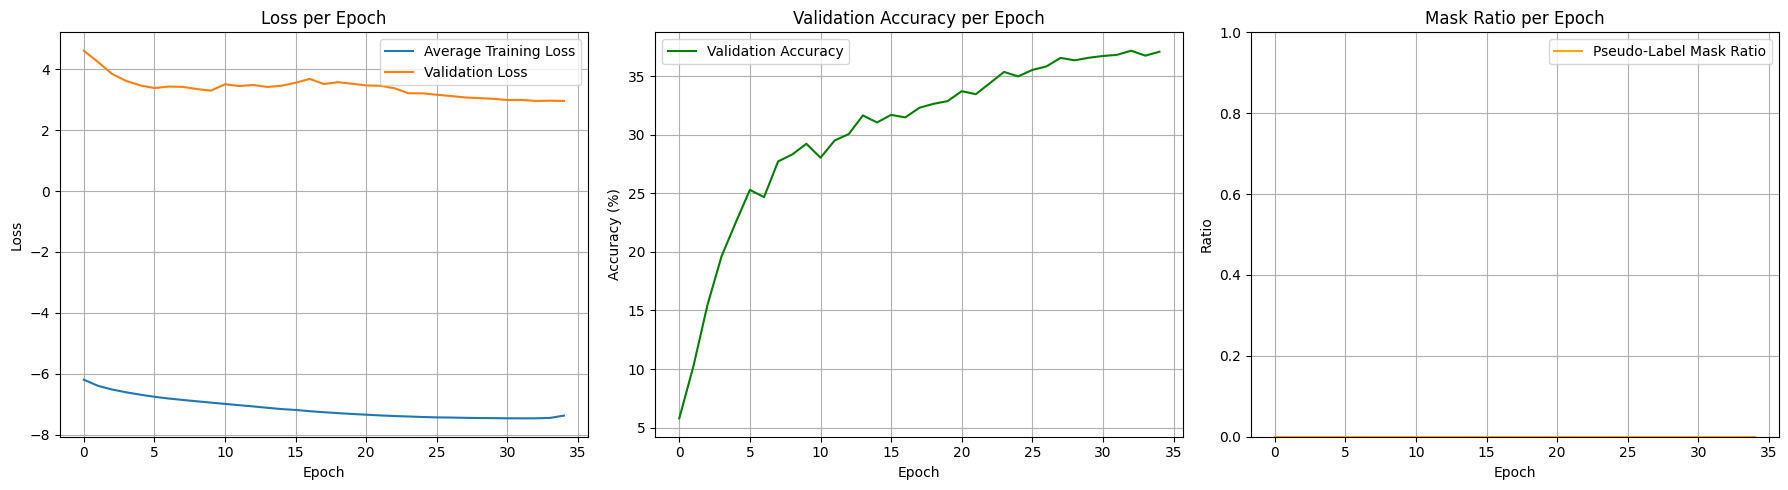

In [10]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Average Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(mask_ratios, label='Pseudo-Label Mask Ratio', color='orange')
plt.title('Mask Ratio per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Ratio')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()